## **Grad-CAM and Grad-CAM++ Implementation**

In [3]:
pip install pytorch-gradcam

     |████████████████████████████████| 6.0 MB 6.4 MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=c4f10d1641819ae1238c4c0d5ba3b2bab033e42202941db5d821c9db610b539b
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam


In [4]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torchvision


from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
#Source directory in drive
directory = '/content/gdrive/MyDrive/Colab Notebooks/Grad CAM/'

In [22]:
#Load image from the image directory 
img_path = "/content/gdrive/MyDrive/Colab Notebooks/Grad CAM//Images/Cats.jpeg"

pil_img = PIL.Image.open(img_path)
pil_img
width, height = pil_img.size
print("Input image : width, Height",(width, height))

Input image : width, Height (733, 418)


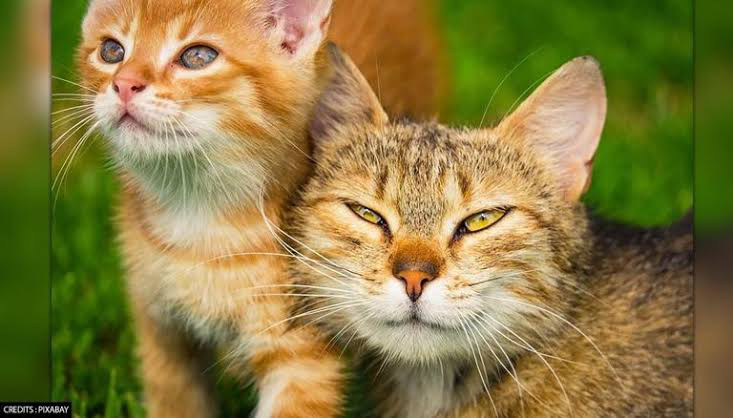

In [37]:
pil_img

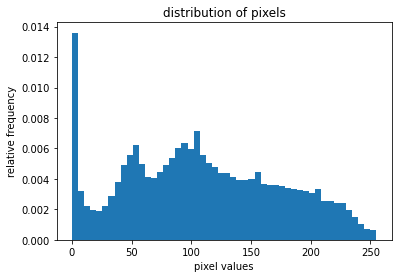

In [38]:
# Distribution of pixel values before transformation
plt.hist(np.array(pil_img).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

In [39]:
#Tranform input Image- Resize before passing to the model
resized_torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img).to(device)

#Image normalization 
normalized_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(resized_torch_img)[None]


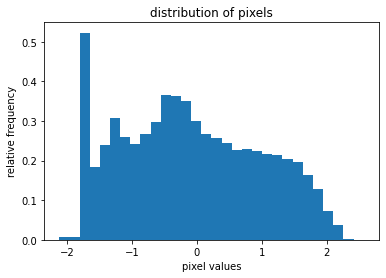

In [40]:
# Distribution of pixel values after transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])
normalized_img = transform(pil_img)

plt.hist(normalized_img.numpy().ravel(), bins=30, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

In [25]:
#Supported architectures in pytorch-gradcam library
model_alexnet = models.alexnet(pretrained=True)
model_vgg = models.vgg16(pretrained=True)
model_resnet = models.resnet101(pretrained=True)
model_densenet = models.densenet161(pretrained=True)
model_squeezenet = models.squeezenet1_1(pretrained=True)

In [41]:
# Storing the models as dictionary item with the respective layers where gradients will be taken
loaded_configs = [
    dict(model_type='alexnet', arch=model_alexnet, layer_name='features_11'),
    dict(model_type='vgg', arch=model_vgg, layer_name='features_29'),
    dict(model_type='resnet', arch=model_resnet, layer_name='layer4'),
    dict(model_type='densenet', arch=model_densenet, layer_name='features_norm5'),
    dict(model_type='squeezenet', arch=model_squeezenet, layer_name='features_12_expand3x3_activation')
]

In [42]:
# Load the config to the "Grad CAM" and "Grad CAM ++" 
# Only "Grad CAM" and "Grad CAM ++" available in this library
for model_config in loaded_configs:
    model_config['arch'].to(device).eval()

#Save "Grad CAM" and "Grad CAM ++" instances for all available architectures(loaded_configs)
cams = [[cls.from_config(**model_config) for cls in (GradCAM, GradCAMpp)] for model_config in loaded_configs]

In [43]:
#Load the normalized image to the "gradcam , gradcam ++" function under each architecture to produce heatmaps and result
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normalized_torch_img)
    heatmap, result = visualize_cam(mask, resized_torch_img)

    mask_pp, _ = gradcam_pp(normalized_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, resized_torch_img)
    
    images.extend([resized_torch_img.cpu(),result,result_pp])
    
#Grid the original image, result from gradcam, result from gradcam++
grid_image = make_grid(images, nrow=3)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [44]:
#Tranform back to PIL image to show the output
grid=transforms.ToPILImage()(grid_image)

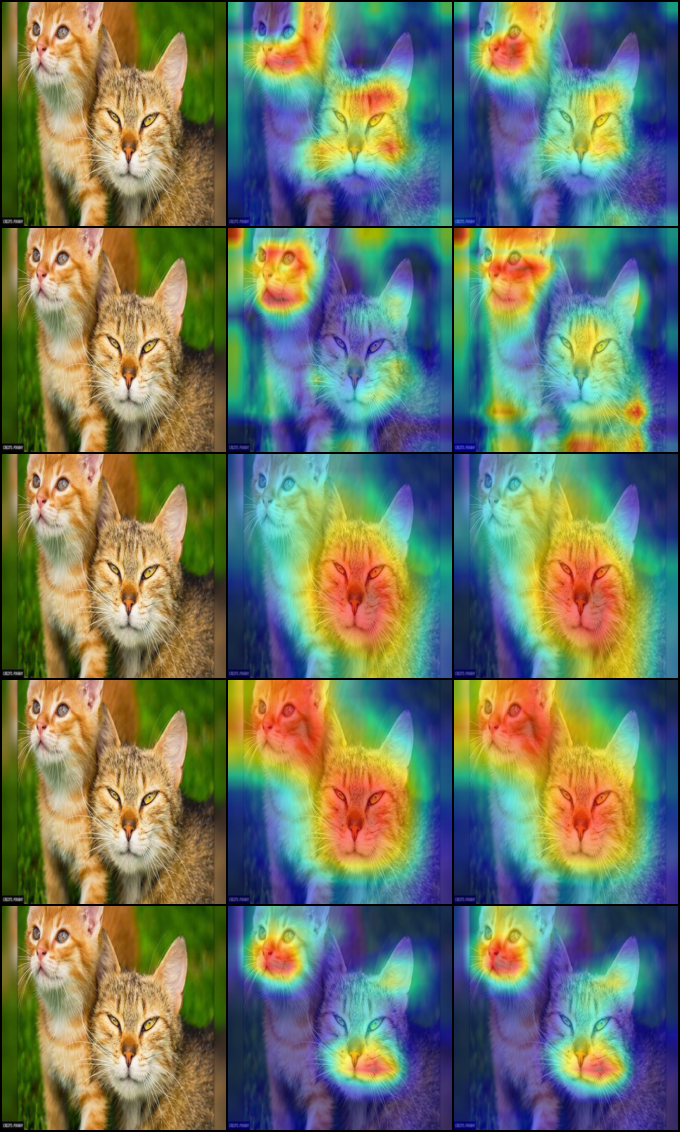

In [45]:
#Original image, result from gradcam, result from gradcam++
grid

## **Neural Based decision trees (NBDT) Implementation**

In [5]:
pip install nbdt

     |████████████████████████████████| 119 kB 5.5 MB/s 
     |████████████████████████████████| 532 kB 26.0 MB/s 
  Created wheel for nbdt: filename=nbdt-0.0.4-py3-none-any.whl size=132338 sha256=9c0d29efcb9a6723020d937a34b5f808516d538f8f9b9052dfbd3e7b38973bb6
  Stored in directory: /root/.cache/pip/wheels/1f/3f/10/02973cef706abb89dd9ed79337887e7eeddd4ebbb36f6cfa2b
Successfully built nbdt


In [6]:
#install nltk
#download wordnet for building the heirerchy in the next step
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [32]:
#import necessary libraries from nbdt package
from nbdt.model import SoftNBDT, HardNBDT
from pytorchcv.models.wrn_cifar import wrn28_10_cifar10
from torchvision import transforms
from nbdt.utils import DATASET_TO_CLASSES, load_image_from_path, maybe_install_wordnet
import sys

maybe_install_wordnet()

#Function to load NBDT model with pre-trained weights
def load_model():
    model = wrn28_10_cifar10()
    model = HardNBDT(
      pretrained=True,
      dataset='CIFAR10',
      arch='wrn28_10_cifar10',
      model=model)
    return model


#Function to Load image and perform image transformation (resize,center crop,converting to tensor,normalozation) 
def load_image():
    """Load + transform image"""
    assert len(sys.argv) > 1
    im = load_image_from_path("https://bsmedia.business-standard.com/media-handler.php?mediaPath=https://bsmedia.business-standard.com/_media/bs/img/article/2019-12/23/full/1577083902-3265.jpg&width=1200")
    transform = transforms.Compose([
      transforms.Resize(32),
      transforms.CenterCrop(32),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    x = transform(im)[None]
    return x


#Function to output the classification result and heirerchy
def heirerchy_output(outputs, decisions):
    _, predicted = outputs.max(1)
    predicted_class = DATASET_TO_CLASSES['CIFAR10'][predicted[0]]
    print('Predicted Class:', predicted_class, 
          '\n\nHeirerchy:',
          ', '.join(['\n{} ({:.2f}%)'.format(info['name'], info['prob'] * 100) 
          for info in decisions[0]][1:]))


def main():
    model = load_model()
    x = load_image()
    outputs, decisions = model.forward_with_decisions(x)
    heirerchy_output(outputs, decisions)


if __name__ == '__main__':
    main()

Predicted Class: horse 

Heirerchy: 
animal (99.52%), 
ungulate (98.52%), 
horse (99.71%)
